In [2]:
import torch
import torch.nn as nn
from transformers import (
    pipeline,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoConfig,
)
from IPython.display import Markdown
from huggingface_hub import notebook_login
from datasets import load_dataset
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
import chromadb
import numpy as np

In [2]:
# Load PTB dataset (Penn Treebank)
dataset = load_dataset("ptb_text_only")

documents = []
for item in dataset["train"]:
    # For the "ptb_text_only" config, the text is typically in item["sentence"]
    text = item["sentence"]
    documents.append(text)

# Use the recursive character splitter
recur_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=60, separators=["\n\n", "\n", "\.", " ", ""]
)

# Perform the splits using the splitter
data_splits = recur_splitter.split_text("".join(documents))
print("Number of splits:", len(data_splits))

<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
/var/folders/85/n4szm2s17gq0mb_1nh56kw9c0000gn/T/ipykernel_84855/104688228.py:12: SyntaxWarning: invalid escape sequence '\.'
  chunk_size=1000, chunk_overlap=60, separators=["\n\n", "\n", "\.", " ", ""]


Number of splits: 5293


In [3]:
### Using embeddings by MPNET: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda" if torch.cuda.is_available() else "cpu"}
encode_kwargs = {"normalize_embeddings": False}
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

/var/folders/85/n4szm2s17gq0mb_1nh56kw9c0000gn/T/ipykernel_85137/3328698620.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embeddings = HuggingFaceEmbeddings(


In [4]:
persist_directory = "./vector_store/"
original_client = chromadb.PersistentClient(path=persist_directory)
org_collection = original_client.get_collection(name="langchain")

org_data = original_data = org_collection.get(include=["embeddings", "documents"])

In [7]:
org_emb = torch.Tensor(original_data["embeddings"])
print(org_emb.shape)

torch.Size([5293, 768])


In [30]:
def topk_cosine_sim(x: torch.Tensor, k: int):
    x = torch.nn.functional.normalize(x, p=2, dim=1)  # normalize to unit vectors
    sim_matrix = x @ x.T  # cosine similarity
    topk_sim, topk_idx = torch.topk(
        sim_matrix, k=k, dim=1
    )  # +1 because self-similarity is 1
    return topk_sim[:, :], topk_idx[:, :]  # remove self-match

In [56]:
_, brute_force_idx = topk_cosine_sim(org_emb, k=10)
print(brute_force_idx[0])

tensor([   0,    3,    2,    1, 5082,   59, 4967, 3340,  496,  387])


In [32]:
def uniform_quantization(tensor: torch.Tensor, clip_val: torch.Tensor, bit):
    scale = (2 ** (bit - 1)) - 1
    tensor_q: torch.Tensor = tensor.clamp(-clip_val, clip_val) / clip_val * scale
    tensor_q = (tensor_q.round() - tensor_q).detach() + tensor_q  # STE 적용
    tensor_q_int = tensor_q.to(torch.int8)
    # print(tensor_q_int)
    msb_2_bits = tensor_q_int & 0xC0
    mid_2_bits = tensor_q_int & 0x30
    mid2_2_bits = tensor_q_int & 0x0C
    lsb_4_bits = tensor_q_int & 0x03
    # print(msb_2_bits, mid_2_bits, mid2_2_bits, lsb_4_bits)
    msb_2_bits_scaled = msb_2_bits / scale * clip_val
    mid_2_bits_scaled = mid_2_bits / scale * clip_val
    mid2_2_bits_scaled = mid2_2_bits / scale * clip_val
    lsb_4_bits_scaled = lsb_4_bits / scale * clip_val
    # print(msb_2_bits_scaled, mid_2_bits_scaled, mid2_2_bits_scaled, lsb_4_bits_scaled)
    # return msb_2_bits_scaled, mid_2_bits_scaled, mid2_2_bits_scaled, lsb_4_bits_scaled
    return tensor_q_int / scale * clip_val

In [14]:
def noise_inject_tensor(weight_tensor: torch.Tensor, std: torch.Tensor, typ: bool):
    device = weight_tensor.device
    std = std.to(device)
    if typ:
        std_reshaped = std.view(-1, 1) if std.dim() == 1 else std
        adjusted_noise = 1.0 + std_reshaped * torch.randn_like(weight_tensor)
    else:
        adjusted_noise = 1.0 + std * torch.randn_like(weight_tensor)
    return torch.mul(weight_tensor, adjusted_noise).to(device)

In [16]:
print(org_emb.max(), org_emb.min())
print(org_emb.mean(), org_emb.std())

tensor(0.2058) tensor(-0.2178)
tensor(-0.0001) tensor(0.0361)


In [19]:
cliff_val = org_emb.std() * 3
print(cliff_val)
org_emb_q = uniform_quantization(org_emb, cliff_val, 8)

q_collection = original_client.get_or_create_collection(
    name=f"q_cliff_{cliff_val}",
    # embedding_function=hf_embeddings,
    metadata={"hnsw:space": "cosine"},
)
quantized_data = q_collection.get(include=["embeddings"])
print(len(quantized_data["embeddings"]))

tensor(0.1083)
0


In [24]:
print(len(org_emb_q))
print(list(range(len(org_emb_q))))

5293
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

In [64]:
base_collection = original_client.get_or_create_collection(
    name=f"base",
    # embedding_function=hf_embeddings,
    metadata={"hnsw:space": "cosine"},
)
base_data = base_collection.get(include=["embeddings"])
print(len(base_data["embeddings"]))

0


In [65]:
base_collection.add(
    ids=[str(i) for i in range(len(org_emb))],
    embeddings=org_emb.numpy(),
    documents=org_data["documents"],
),

(None,)

In [34]:
q_collection.add(
    ids=[str(i) for i in range(len(org_emb_q))],
    embeddings=org_emb_q.numpy(),
    documents=org_data["documents"],
),

(None,)

In [33]:
q_collection.delete(ids=[str(i) for i in range(len(org_emb_q))])

In [38]:
org_data["ids"]
id_idx_map = {id: idx for idx, id in enumerate(org_data["ids"])}

In [ ]:
q_match = 0
match = 0
k = 10

for idx, query in enumerate(org_emb):
    q_query_result = q_collection.query(
        query_embeddings=query.numpy(),
        n_results=k,
        include=["documents", "embeddings"],
    )
    query_result = org_collection.query(
        query_embeddings=query.numpy(),
        n_results=k,
        include=["documents", "embeddings"],
    )
    query_idx = set(map(lambda x: id_idx_map[x], query_result["ids"][0]))
    q_query_idx = set(map(lambda x: int(x), q_query_result["ids"][0]))
    bf = set(map(lambda x: int(x), brute_force_idx[idx]))
    # print(query_idx, q_query_idx, bf)
    match += len(query_idx.intersection(bf))
    q_match += len(q_query_idx.intersection(bf))
    # break
print("recall:", match / (k * len(org_emb)))
print("q_recall:", q_match / (k * len(org_emb)))

recall: 0.9990175703759683
q_recall: 0.9845078405441149


In [ ]:
cliff_val_list = [3, 4, 5, 6, 7, 8, 9, 10]
noise_std = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]
for cliff_val in cliff_val_list:
    org_emb_q = uniform_quantization(org_emb, cliff_val * org_emb.std(), 8)
    q_collection = original_client.get_or_create_collection(
        name=f"q_cliff_{cliff_val}",
        metadata={"hnsw:space": "cosine"},
    )
    if len(q_collection.get(include=["embeddings"])["embeddings"]) == len(org_emb):
        print("already exist for cliff_val", cliff_val)
    else:
        q_collection.add(
            ids=[str(i) for i in range(len(org_emb_q))],
            embeddings=org_emb_q.numpy(),
            documents=org_data["documents"],
        ),
    for std in noise_std:
        noise_emb = noise_inject_tensor(org_emb_q, torch.Tensor([std]), True)
        q_n_collection = original_client.get_or_create_collection(
            name=f"q_cliff_{cliff_val}_noise_{std}",
            metadata={"hnsw:space": "cosine"},
        )
        if len(q_n_collection.get(include=["embeddings"])["embeddings"]) == len(
            org_emb
        ):
            print("already exist for cliff_val", cliff_val, "std", std)
        else:
            q_n_collection.add(
                ids=[str(i) for i in range(len(noise_emb))],
                embeddings=noise_emb.numpy(),
                documents=org_data["documents"],
            ),

already exist for cliff_val 3


In [71]:
cliff_val_list = [3, 4, 5, 6, 7, 8, 9, 10]
noise_std = [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 0.7, 1]
collection_names = []
k = 10
for i in range(len(cliff_val_list)):
    collection_names.append(f"q_cliff_{cliff_val_list[i]}")
    for j in range(len(noise_std)):
        collection_names.append(f"q_cliff_{cliff_val_list[i]}_noise_{noise_std[j]}")
print(collection_names)
match_counter = {name: 0 for name in collection_names}
match_counter["base"] = 0

['q_cliff_3', 'q_cliff_3_noise_0.01', 'q_cliff_3_noise_0.03', 'q_cliff_3_noise_0.05', 'q_cliff_3_noise_0.07', 'q_cliff_3_noise_0.1', 'q_cliff_3_noise_0.3', 'q_cliff_3_noise_0.5', 'q_cliff_3_noise_0.7', 'q_cliff_3_noise_1', 'q_cliff_4', 'q_cliff_4_noise_0.01', 'q_cliff_4_noise_0.03', 'q_cliff_4_noise_0.05', 'q_cliff_4_noise_0.07', 'q_cliff_4_noise_0.1', 'q_cliff_4_noise_0.3', 'q_cliff_4_noise_0.5', 'q_cliff_4_noise_0.7', 'q_cliff_4_noise_1', 'q_cliff_5', 'q_cliff_5_noise_0.01', 'q_cliff_5_noise_0.03', 'q_cliff_5_noise_0.05', 'q_cliff_5_noise_0.07', 'q_cliff_5_noise_0.1', 'q_cliff_5_noise_0.3', 'q_cliff_5_noise_0.5', 'q_cliff_5_noise_0.7', 'q_cliff_5_noise_1', 'q_cliff_6', 'q_cliff_6_noise_0.01', 'q_cliff_6_noise_0.03', 'q_cliff_6_noise_0.05', 'q_cliff_6_noise_0.07', 'q_cliff_6_noise_0.1', 'q_cliff_6_noise_0.3', 'q_cliff_6_noise_0.5', 'q_cliff_6_noise_0.7', 'q_cliff_6_noise_1', 'q_cliff_7', 'q_cliff_7_noise_0.01', 'q_cliff_7_noise_0.03', 'q_cliff_7_noise_0.05', 'q_cliff_7_noise_0.07', 'q

In [ ]:
k = 10
_, brute_force_idx = topk_cosine_sim(org_emb, k=k)
for idx, query in enumerate(org_emb):
    bf = set(map(lambda x: int(x), brute_force_idx[idx]))
    for collection_name in collection_names:
        collection = original_client.get_collection(name=collection_name)
        q_query_result = collection.query(
            query_embeddings=query.numpy(),
            n_results=k,
            include=["documents", "embeddings"],
        )
        q_query_idx = set(map(lambda x: int(x), q_query_result["ids"][0]))
        match_counter[collection_name] += len(q_query_idx.intersection(bf))
    if idx % 1000 == 0:
        print(f"Processed {idx} queries")

Processed 0 queries
Processed 10 queries
Processed 20 queries
Processed 30 queries
Processed 40 queries
Processed 50 queries
Processed 60 queries
Processed 70 queries
Processed 80 queries
Processed 90 queries
Processed 100 queries
Processed 110 queries
Processed 120 queries
Processed 130 queries
Processed 140 queries
Processed 150 queries
Processed 160 queries
Processed 170 queries
Processed 180 queries
Processed 190 queries
Processed 200 queries
Processed 210 queries
Processed 220 queries
Processed 230 queries
Processed 240 queries
Processed 250 queries
Processed 260 queries
Processed 270 queries
Processed 280 queries
Processed 290 queries
Processed 300 queries
Processed 310 queries
Processed 320 queries
Processed 330 queries
Processed 340 queries
Processed 350 queries
Processed 360 queries
Processed 370 queries
Processed 380 queries
Processed 390 queries
Processed 400 queries
Processed 410 queries
Processed 420 queries
Processed 430 queries
Processed 440 queries
Processed 450 queries

In [ ]:
print("recall:")
for collection_name in collection_names:
    print(f"{collection_name}: {match_counter[collection_name] / (k * len(org_emb))}")

recall:
q_cliff_3: 0.9845834120536557
q_cliff_3_noise_0.01: 0.9836387681843944
q_cliff_3_noise_0.03: 0.9800680143585868
q_cliff_3_noise_0.05: 0.9752881163801247
q_cliff_3_noise_0.07: 0.9678821084451162
q_cliff_3_noise_0.1: 0.959909314188551
q_cliff_3_noise_0.3: 0.8927451350840733
q_cliff_3_noise_0.5: 0.8146041942187795
q_cliff_3_noise_0.7: 0.7408086151520876
q_cliff_3_noise_1: 0.6260721707916116
q_cliff_4: 0.9944266011713584
q_cliff_4_noise_0.01: 0.992801813716229
q_cliff_4_noise_0.03: 0.9864349140374079
q_cliff_4_noise_0.05: 0.979576799546571
q_cliff_4_noise_0.07: 0.9727753636878896
q_cliff_4_noise_0.1: 0.9614774230115246
q_cliff_4_noise_0.3: 0.8931607783865483
q_cliff_4_noise_0.5: 0.8195352352163234
q_cliff_4_noise_0.7: 0.7414887587379558
q_cliff_4_noise_1: 0.6298318533912715
q_cliff_5: 0.9945210655582846
q_cliff_5_noise_0.01: 0.9930663139996222
q_cliff_5_noise_0.03: 0.985943699225392
q_cliff_5_noise_0.05: 0.9784810126582278
q_cliff_5_noise_0.07: 0.9716228981673909
q_cliff_5_noise_0.

In [83]:
base_match = 0
for query in org_emb:
    q_query_result = base_collection.query(
        query_embeddings=query.numpy(),
        n_results=k,
        include=["documents", "embeddings"],
    )
    query_idx = set(map(lambda x: id_idx_map[x], query_result["ids"][0]))
    bf = set(map(lambda x: int(x), brute_force_idx[idx]))
    base_match += len(query_idx.intersection(bf))
print("base recall:", base_match / (k * len(org_emb)))

base recall: 1.0


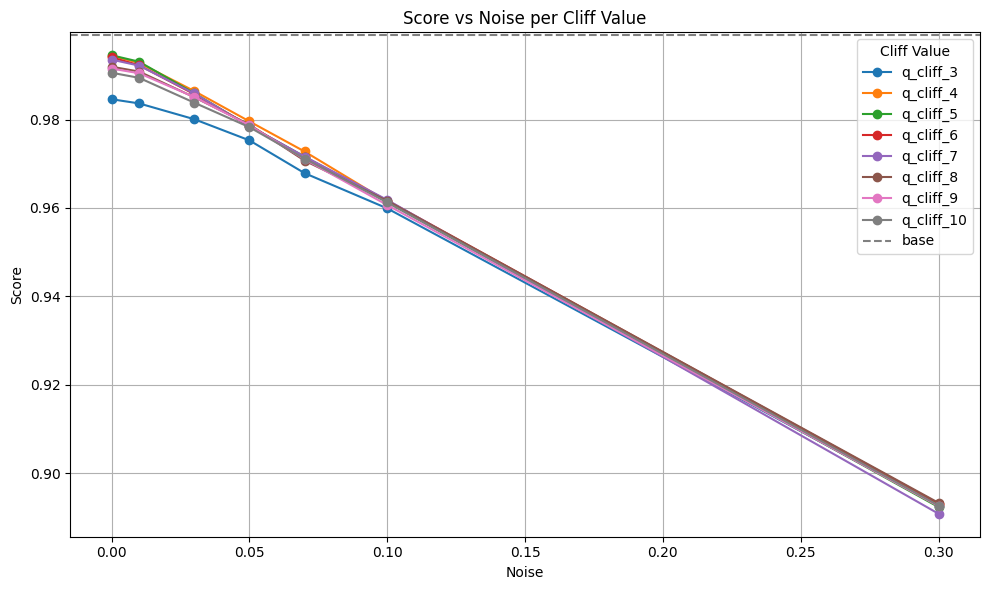

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt


data = []
for key, value in match_counter.items():
    match = re.match(r"q_cliff_(\d+)(?:_noise_([\d.]+))?", key)
    if match:
        cliff = int(match.group(1))
        noise = float(match.group(2)) if match.group(2) else 0.0
        if noise < 0.5:
            data.append((cliff, noise, value / (k * len(org_emb))))
    elif key == "base":
        base = 0.9990175703759683
df = pd.DataFrame(data, columns=["cliff", "noise", "score"])
df_pivot = df.pivot(index="noise", columns="cliff", values="score").sort_index()

# Plot
plt.figure(figsize=(10, 6))
for cliff in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[cliff], label=f"q_cliff_{cliff}", marker="o")

plt.axhline(base, color="gray", linestyle="--", label="base")
plt.xlabel("Noise")
plt.ylabel("Score")
plt.title("Score vs Noise per Cliff Value")
plt.legend(title="Cliff Value")
plt.grid(True)
plt.tight_layout()
plt.show()

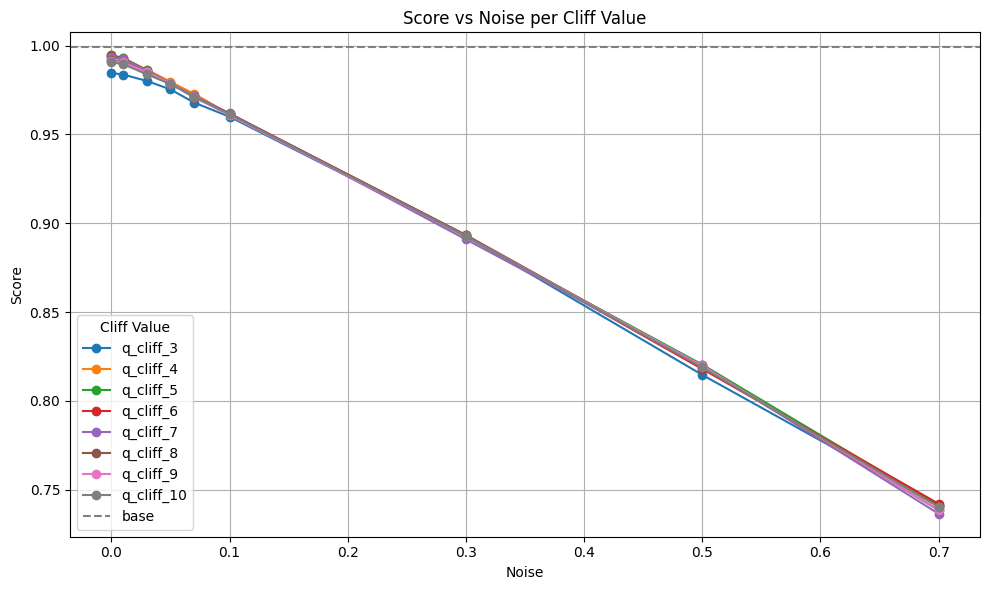

In [7]:
k = 10
match_counter = {
    "q_cliff_3": 0.9845834120536557,
    "q_cliff_3_noise_0.01": 0.9836387681843944,
    "q_cliff_3_noise_0.03": 0.9800680143585868,
    "q_cliff_3_noise_0.05": 0.9752881163801247,
    "q_cliff_3_noise_0.07": 0.9678821084451162,
    "q_cliff_3_noise_0.1": 0.959909314188551,
    "q_cliff_3_noise_0.3": 0.8927451350840733,
    "q_cliff_3_noise_0.5": 0.8146041942187795,
    "q_cliff_3_noise_0.7": 0.7408086151520876,
    "q_cliff_3_noise_1": 0.6260721707916116,
    "q_cliff_4": 0.9944266011713584,
    "q_cliff_4_noise_0.01": 0.992801813716229,
    "q_cliff_4_noise_0.03": 0.9864349140374079,
    "q_cliff_4_noise_0.05": 0.979576799546571,
    "q_cliff_4_noise_0.07": 0.9727753636878896,
    "q_cliff_4_noise_0.1": 0.9614774230115246,
    "q_cliff_4_noise_0.3": 0.8931607783865483,
    "q_cliff_4_noise_0.5": 0.8195352352163234,
    "q_cliff_4_noise_0.7": 0.7414887587379558,
    "q_cliff_4_noise_1": 0.6298318533912715,
    "q_cliff_5": 0.9945210655582846,
    "q_cliff_5_noise_0.01": 0.9930663139996222,
    "q_cliff_5_noise_0.03": 0.985943699225392,
    "q_cliff_5_noise_0.05": 0.9784810126582278,
    "q_cliff_5_noise_0.07": 0.9716228981673909,
    "q_cliff_5_noise_0.1": 0.9613073871150576,
    "q_cliff_5_noise_0.3": 0.892386170413754,
    "q_cliff_5_noise_0.5": 0.8204043075760439,
    "q_cliff_5_noise_0.7": 0.7408464009068582,
    "q_cliff_5_noise_1": 0.6281692801813716,
    "q_cliff_6": 0.9940487436236539,
    "q_cliff_6_noise_0.01": 0.9922728131494427,
    "q_cliff_6_noise_0.03": 0.9857358775741546,
    "q_cliff_6_noise_0.05": 0.9785565841677688,
    "q_cliff_6_noise_0.07": 0.9714528622709239,
    "q_cliff_6_noise_0.1": 0.9616852446627622,
    "q_cliff_6_noise_0.3": 0.8931229926317779,
    "q_cliff_6_noise_0.5": 0.8179293406385792,
    "q_cliff_6_noise_0.7": 0.7420555450595125,
    "q_cliff_6_noise_1": 0.6300585679198942,
    "q_cliff_7": 0.9935386359342527,
    "q_cliff_7_noise_0.01": 0.9921783487625165,
    "q_cliff_7_noise_0.03": 0.9858870205932363,
    "q_cliff_7_noise_0.05": 0.9785376912903835,
    "q_cliff_7_noise_0.07": 0.9716228981673909,
    "q_cliff_7_noise_0.1": 0.9618174948044588,
    "q_cliff_7_noise_0.3": 0.890874740222936,
    "q_cliff_7_noise_0.5": 0.8199319856414132,
    "q_cliff_7_noise_0.7": 0.7364254675987153,
    "q_cliff_7_noise_1": 0.633383714339694,
    "q_cliff_8": 0.9919327413565086,
    "q_cliff_8_noise_0.01": 0.9908369544681656,
    "q_cliff_8_noise_0.03": 0.9850368411109012,
    "q_cliff_8_noise_0.05": 0.9788588702059323,
    "q_cliff_8_noise_0.07": 0.9707160400529,
    "q_cliff_8_noise_0.1": 0.9616096731532212,
    "q_cliff_8_noise_0.3": 0.8933308142830153,
    "q_cliff_8_noise_0.5": 0.8192896278103156,
    "q_cliff_8_noise_0.7": 0.7384658983563197,
    "q_cliff_8_noise_1": 0.6278103155110524,
    "q_cliff_9": 0.9915170980540337,
    "q_cliff_9_noise_0.01": 0.990459096920461,
    "q_cliff_9_noise_0.03": 0.9850935197430569,
    "q_cliff_9_noise_0.05": 0.9786888343094653,
    "q_cliff_9_noise_0.07": 0.9710372189684489,
    "q_cliff_9_noise_0.1": 0.9606650292839599,
    "q_cliff_9_noise_0.3": 0.8925939920649915,
    "q_cliff_9_noise_0.5": 0.8196485924806348,
    "q_cliff_9_noise_0.7": 0.7386359342527867,
    "q_cliff_9_noise_1": 0.6339505006612507,
    "q_cliff_10": 0.9905724541847724,
    "q_cliff_10_noise_0.01": 0.9894199886642736,
    "q_cliff_10_noise_0.03": 0.9838088040808615,
    "q_cliff_10_noise_0.05": 0.9782731910069904,
    "q_cliff_10_noise_0.07": 0.9711694691101455,
    "q_cliff_10_noise_0.1": 0.9612884942376724,
    "q_cliff_10_noise_0.3": 0.8927451350840733,
    "q_cliff_10_noise_0.5": 0.8188173058756849,
    "q_cliff_10_noise_0.7": 0.7402607217079161,
    "q_cliff_10_noise_1": 0.6298129605138862,
    "base": 0.9990175703759683,
}


import pandas as pd
import re
import matplotlib.pyplot as plt


data = []
for key, value in match_counter.items():
    match = re.match(r"q_cliff_(\d+)(?:_noise_([\d.]+))?", key)
    if match:
        cliff = int(match.group(1))
        noise = float(match.group(2)) if match.group(2) else 0.0
        if noise < 1:
            data.append((cliff, noise, value))
    elif key == "base":
        base = 0.9990175703759683
df = pd.DataFrame(data, columns=["cliff", "noise", "score"])
df_pivot = df.pivot(index="noise", columns="cliff", values="score").sort_index()

# Plot
plt.figure(figsize=(10, 6))
for cliff in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[cliff], label=f"q_cliff_{cliff}", marker="o")

plt.axhline(base, color="gray", linestyle="--", label="base")
plt.xlabel("Noise")
plt.ylabel("Score")
plt.title("Score vs Noise per Cliff Value")
plt.legend(title="Cliff Value")
plt.grid(True)
plt.tight_layout()
plt.show()